We are going to create a siamese net for learning a metric to calculate similarities and dissimilarities between different types of images.

<img src="https://i.ibb.co/FV4pj65/siamese.png" alt="Alex-Net-architecture" border="0" />

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import time

## Simple Siamese-Net with Fashion MNIST

Fashion MNIST dataset contains 70,000 grayscale images with 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels).

In [ ]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0


class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
    'Sneaker', 'Bag', 'Ankle boot'
]

In [ ]:
# We create triplets where the anchor and the positive have the same class.
# The negative has different class
def create_triplets(images, labels, n_triplets_per_class=10000):
    triplets = [] # (anchor, positive, negative)
    n_labels = len(np.unique(labels))
    for class_ind in range(n_labels):
        # Iterate over the classes
        pos_class_inds = np.argwhere(labels == class_ind).flatten()
        neg_class_inds = np.argwhere(labels != class_ind).flatten()
        for _ in range(n_triplets_per_class):
            # anchor
            anchor_ind = np.random.choice(pos_class_inds)
            anchor = images[anchor_ind]
            # positive
            pos_ind = np.random.choice(pos_class_inds)
            positive = images[pos_ind]
            # negative
            neg_ind = np.random.choice(neg_class_inds)
            negative = images[neg_ind]
            # add triplet
            triplets.append((anchor, positive, negative))
    triplets = np.array(triplets)
    return triplets

train_triplets = create_triplets(train_images, train_labels, 10000)

In [ ]:
train_triplets.shape

(100000, 3, 28, 28)

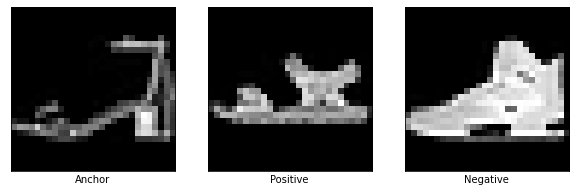

In [ ]:
plt.figure(figsize=(10,10))
ind = np.random.randint(len(train_triplets))
labels = ['Anchor', 'Positive', 'Negative']
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_triplets[ind,i,:,:], cmap='gray')
    plt.xlabel(labels[i])
plt.show()

### Triplet Loss

- A is  "Anchor"
- P is  "Positive"
- N is  "Negative"

 $(A^{(i)}, P^{(i)}, N^{(i)})$   is the $i$-th training triplet.

You'd like to make sure that an image $A^{(i)}$  is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$\mid \mid \mathrm{vec}(A^{(i)}) - \mathrm{vec}(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid \mathrm{vec}(A^{(i)}) - \mathrm{vec}(N^{(i)}) \mid \mid_2^2$$

We want to minimize the  "triplet cost":

$$\mathcal{J}(A,P,N) = \sum^{m}_{i=1} \max \left(  \small \underbrace{\mid \mid \mathrm{vec}(A^{(i)}) - \mathrm{vec}(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid \mathrm{vec}(A^{(i)}) - \mathrm{vec}(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha  , 0 \right) $$

- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small.
```python
pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
```

- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large. It has a minus sign preceding it because minimizing the negative of the term is the same as maximizing that term.
```python
neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
```

- $\alpha$ is  the margin.



In [ ]:
def triplet_loss(y_true, y_pred, margin = 0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
    return tf.reduce_mean(loss)


def distance(vec1, vec2):
    return tf.reduce_sum(tf.square(vec1 - vec2))

### Create Model

First of all, we create the shared `base_model`

In [ ]:
vec_dim = 64

inputs = tf.keras.Input(shape=(28,28,))
x = layers.Flatten(name="flatten_input")(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25, name="second_dropout")(x)

x = layers.Dense(vec_dim, activation='linear')(x)
# L2 normalize
x = layers.Lambda(lambda z: tf.math.l2_normalize(z,axis=1))(x)

base_model = tf.keras.Model(inputs=inputs, outputs=x, name='base_model')

base_model.summary()

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_input (Flatten)      (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
second_dropout (Dropout)     (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

In [ ]:
# Input triplets (anchor, positive, negative)
inputs = tf.keras.Input(shape=(3, 28, 28), name='inputs')

## Anchor vector
anchor_input = inputs[:, 0, :, :]
anchor_vec = base_model(anchor_input)

## Positive vector
positive_input = inputs[:, 1, :, :]
positive_vec = base_model(positive_input)

## Negative vector
negative_input = inputs[:, 2, :, :]
negative_vec = base_model(negative_input)

## stack all the vectors dim: (3, none, vec_dim)
outputs = tf.stack([anchor_vec, positive_vec, negative_vec])
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
y = np.zeros(len(train_triplets))

In [ ]:
model.compile(loss=triplet_loss,optimizer='adam')
history = model.fit(train_triplets, y, epochs=3, validation_split=0.15, batch_size=128, shuffle=True)

Epoch 1/3
665/665 [==============================] - 7s 9ms/step - loss: 0.0630 - val_loss: 0.0194
Epoch 2/3
665/665 [==============================] - 4s 6ms/step - loss: 0.0343 - val_loss: 0.0242
Epoch 3/3
665/665 [==============================] - 4s 6ms/step - loss: 0.0295 - val_loss: 0.0136


### Visualize the results

In [ ]:
#(test_images, test_labels)
image = test_images[5]
image_vec = base_model(np.expand_dims(image, 0))
image.shape, image_vec.shape, image_vec

((28, 28),
 TensorShape([1, 64]),
 <tf.Tensor: shape=(1, 64), dtype=float32, numpy=
 array([[-0.1832266 ,  0.14079002,  0.0497699 ,  0.08019486, -0.04670747,
          0.0453861 , -0.12089615, -0.09200928,  0.21720935,  0.02309496,
         -0.04967145, -0.05529382,  0.16920875,  0.0467264 ,  0.06738512,
         -0.08184604, -0.0369206 ,  0.03862368, -0.01174614, -0.05467914,
          0.03600808,  0.05748068,  0.04629614,  0.02698389, -0.04367118,
         -0.02508212, -0.14483126,  0.12840429, -0.2426351 ,  0.07307329,
          0.03138195,  0.13698928, -0.13212673,  0.16508104,  0.06047919,
         -0.18513924, -0.03919306, -0.16881604,  0.0115767 , -0.15087016,
         -0.08549782, -0.0468503 , -0.00501573,  0.18544342,  0.05149991,
         -0.10327052, -0.06456555,  0.18921599, -0.2641523 , -0.16728346,
          0.22299919,  0.13645254, -0.00822131,  0.18078995, -0.20332132,
         -0.03153478,  0.18537124, -0.14481734,  0.1059307 ,  0.02499613,
         -0.15331668,  0.124

--------------------------------------------------------------------------------
T-shirt/top 0


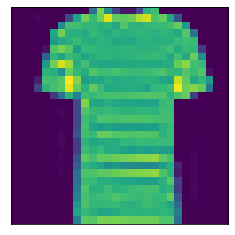

distances:


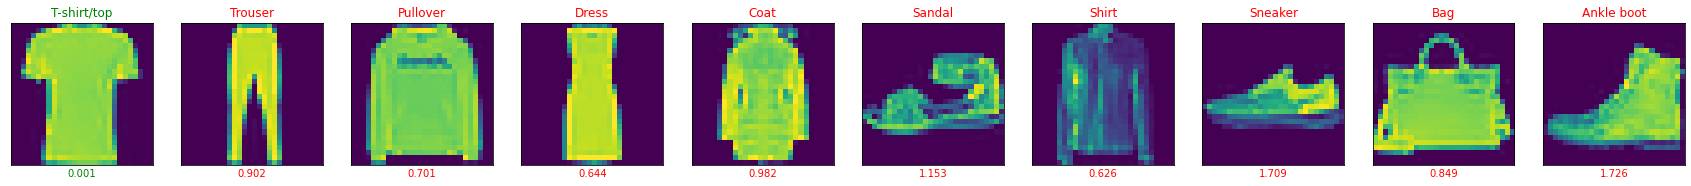

--------------------------------------------------------------------------------
Trouser 1


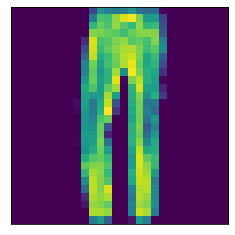

distances:


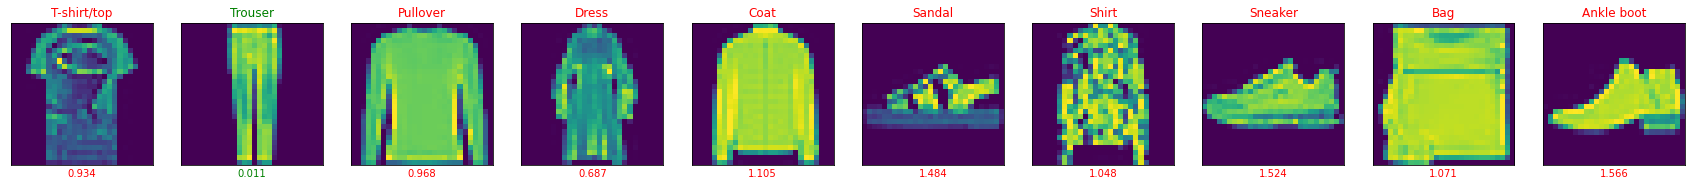

--------------------------------------------------------------------------------
Pullover 2


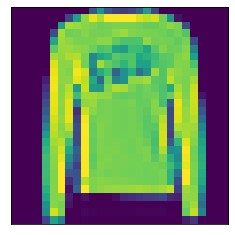

distances:


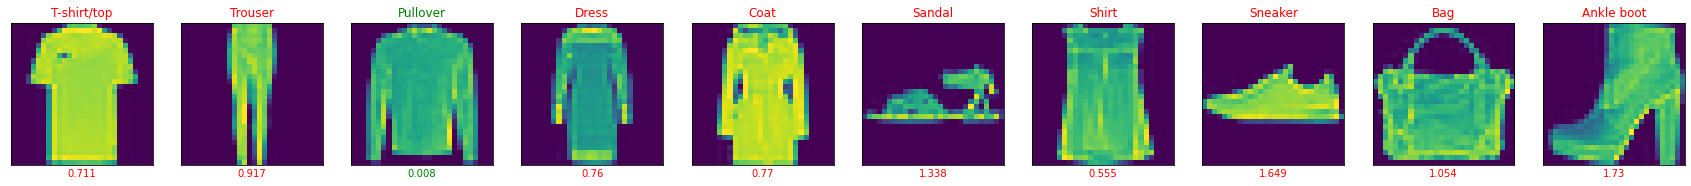

--------------------------------------------------------------------------------
Dress 3


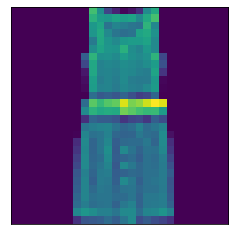

distances:


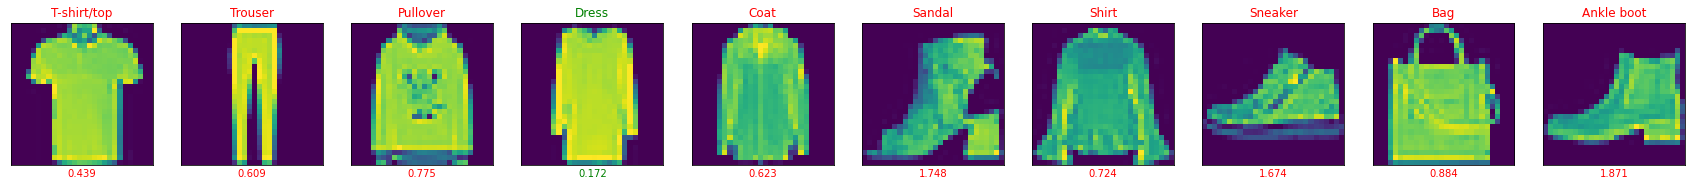

--------------------------------------------------------------------------------
Coat 4


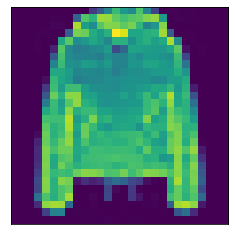

distances:


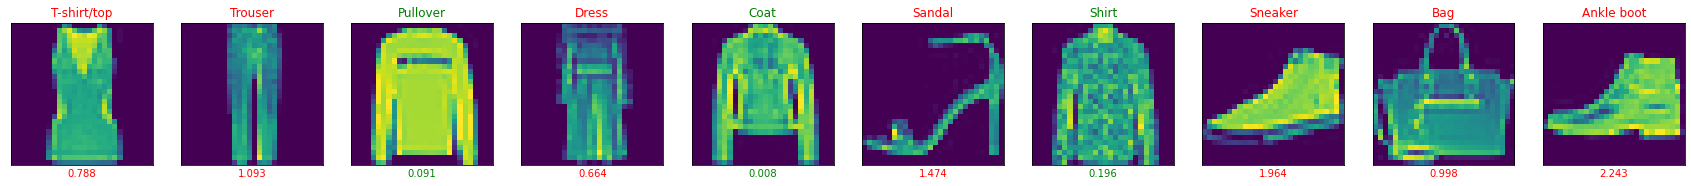

--------------------------------------------------------------------------------
Sandal 5


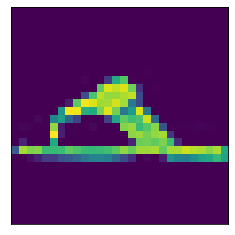

distances:


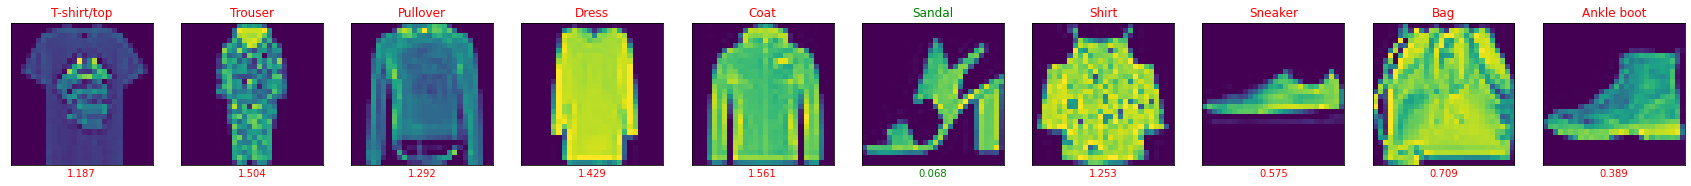

--------------------------------------------------------------------------------
Shirt 6


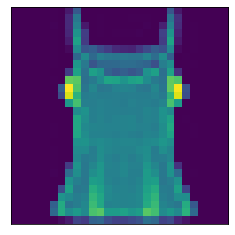

distances:


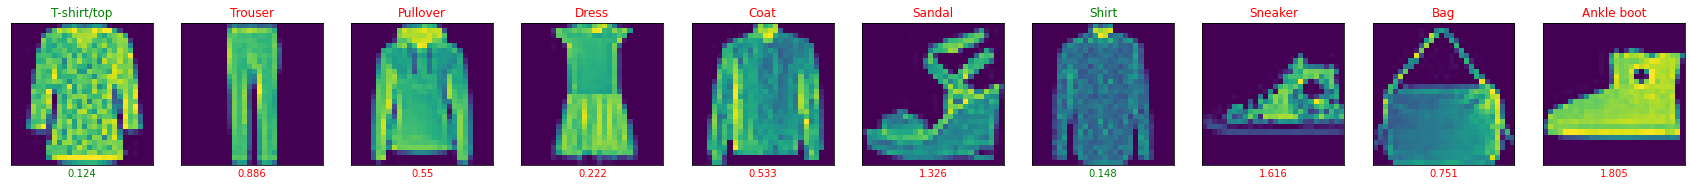

--------------------------------------------------------------------------------
Sneaker 7


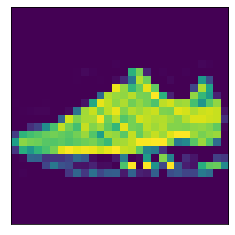

distances:


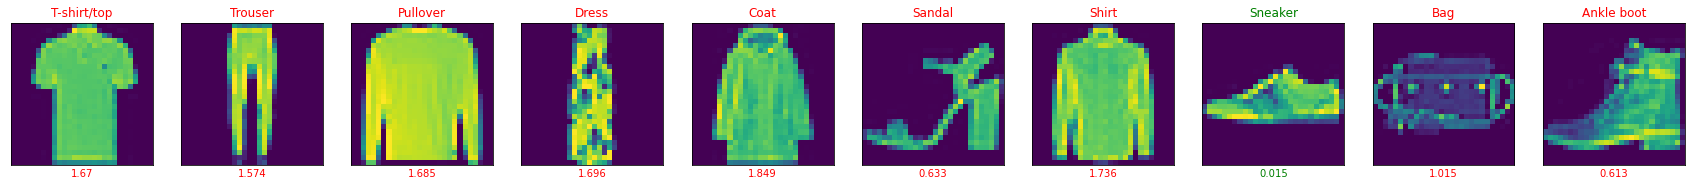

--------------------------------------------------------------------------------
Bag 8


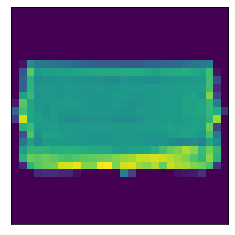

distances:


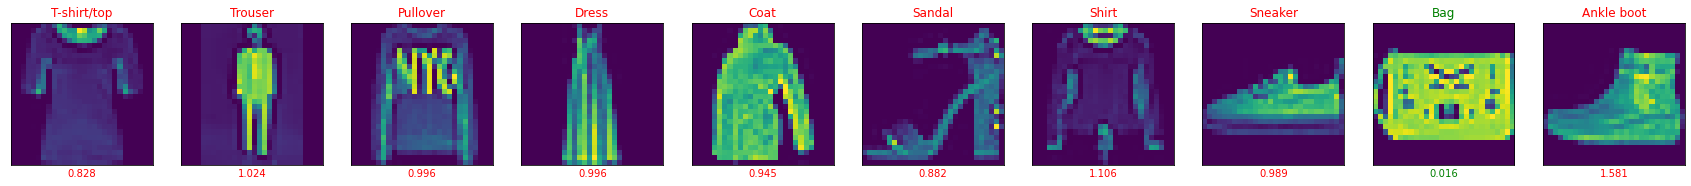

--------------------------------------------------------------------------------
Ankle boot 9


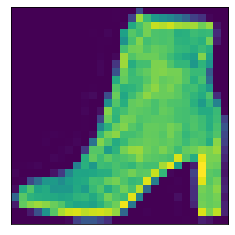

distances:


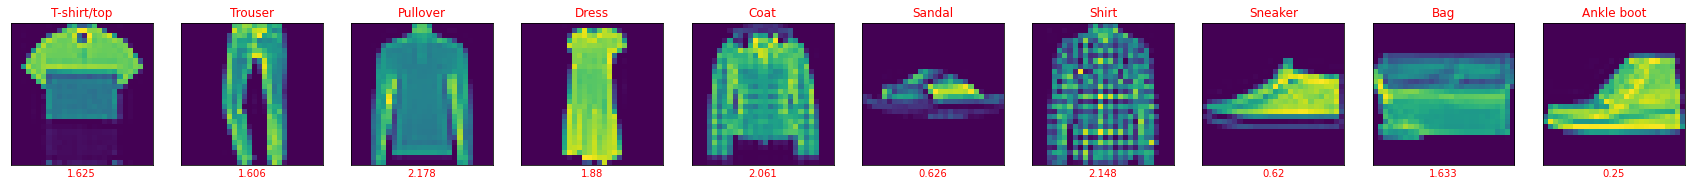

In [ ]:
def plot_images_dis(base_model, image_vec, images, labels, class_names, margin=0.2):
    plt.figure(figsize=(30, 30))
    for class_ind in range(len(class_names)):
        class_name = class_names[class_ind]
        class_inds = np.argwhere(labels == class_ind).flatten()
        image_class = np.squeeze(images[np.random.choice(class_inds)])
        image_class_vec = base_model(np.expand_dims(image_class, 0))
        dis = np.round(distance(image_vec, image_class_vec), 3)
        dis_str = str(dis)
        if dis < margin:
            color = 'green'
        else:
            color = 'red'
        plt.subplot(1, len(class_names), class_ind + 1)
        plt.title(class_name, color=color)
        plt.xlabel(dis_str, color=color)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_class)
    plt.show()

for class_ind in range(10):
    print('-'*80)
    class_name = class_names[class_ind]
    print(class_name, class_ind)
    class_inds = np.argwhere(test_labels == class_ind).flatten()
    image = np.squeeze(test_images[np.random.choice(class_inds)])
    image_vec = base_model(np.expand_dims(image, 0))

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()
    print('distances:')
    plot_images_dis(base_model, image_vec, test_images, test_labels, class_names)

### Similarity and Confusion Matrix

In [ ]:
def calculate_nearest_class(image_vec, image_class, vecs, labels):
    '''Find the neares class of a single image vector'''
    # vectors are normalized: argmin_i |v -v_i| = argmax_i v_i.dot(v)
    most_similar_ind = np.argsort(-vecs.dot(image_vec))[1]
    # index 0 is for the same vector
    nearest_class = labels[most_similar_ind]
    return nearest_class


def calculate_confusion_matrix(vecs, labels, class_names, samples=20):
    num_classes = len(class_names)
    confusion_matrix = np.zeros((num_classes, num_classes))
    for class_ind in range(num_classes):
        pos_class_inds = np.argwhere(labels == class_ind).flatten()
        class_samples = np.random.choice(pos_class_inds, samples)
        for sample_ind in class_samples:
            image_vec = vecs[sample_ind, :]
            nn_class = calculate_nearest_class(image_vec, class_ind, vecs,
                                               labels)
            confusion_matrix[class_ind, nn_class] += 1
    return confusion_matrix

In [ ]:
test_vecs = base_model(test_images).numpy()
confusion_matrix = calculate_confusion_matrix(test_vecs,
                                              test_labels,
                                              class_names,
                                              samples=99)

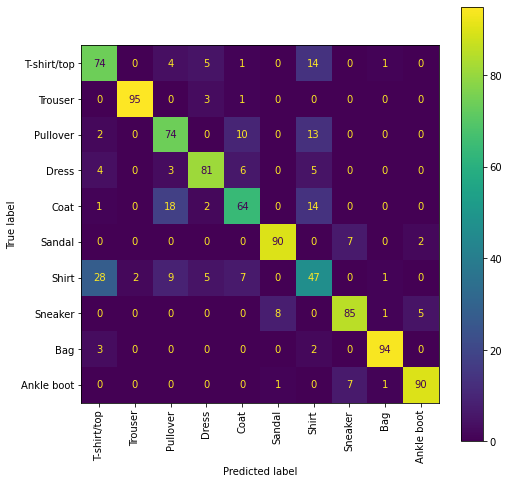

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                             display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8));
cmp.plot(ax=ax, xticks_rotation="vertical", include_values=True)

In [ ]:
def calculate_diff_nearest_class(image_vec, image_class, vecs, labels):
    '''Find the nearest different class of a single image vector'''
    # Different class indexes
    neg_class_inds = np.argwhere(labels != image_class).flatten()
    # Vectors of different class
    neg_vecs = vecs[neg_class_inds, :]
    # vectors are normalized: argmin_i |v -v_i| = argmax_i v_i.dot(v)
    most_similar_ind = np.argmax(neg_vecs.dot(image_vec))
    nearest_class = labels[neg_class_inds[most_similar_ind]]
    return nearest_class

def calculate_nearest_classes(vecs, labels, class_names, samples=20):
    num_classes = len(class_names)
    nearest_classes = np.zeros((num_classes, num_classes))
    for class_ind in range(num_classes):
        pos_class_inds = np.argwhere(labels == class_ind).flatten()
        class_samples = np.random.choice(pos_class_inds, samples)
        for sample_ind in class_samples:
            image_vec = vecs[sample_ind, :]
            nn_class = calculate_diff_nearest_class(image_vec, class_ind, vecs,
                                                    labels)
            nearest_classes[class_ind, nn_class] += 1
    return nearest_classes


test_vecs = base_model(test_images).numpy()
nearest_classes = calculate_nearest_classes(test_vecs,
                                              test_labels,
                                              class_names,
                                              samples=50)

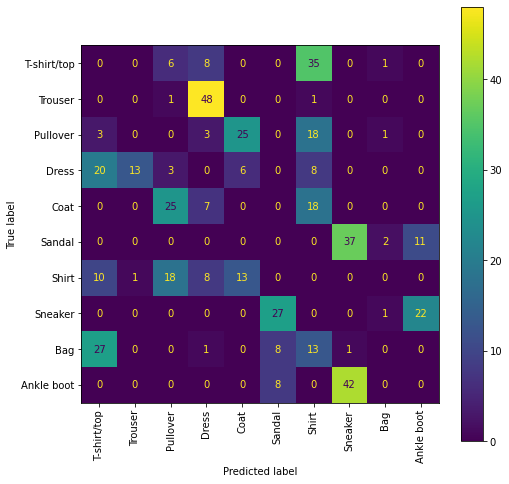

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp = ConfusionMatrixDisplay(confusion_matrix=nearest_classes, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation="vertical", include_values=True);

### Question 1: Create a convolutional base model

In [ ]:
# load the dataset
(train_images,
 train_labels), (test_images,
                 test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
    'Sneaker', 'Bag', 'Ankle boot'
]

In [ ]:
train_triplets = create_triplets(train_images, train_labels, 10000)
train_triplets.shape

(100000, 3, 28, 28, 1)

In [ ]:
vec_dim = 64

inputs = tf.keras.Input(shape=(28, 28, 1))

## convolutional layers
# Conv Layer 1
conv_1 = layers.Conv2D(32, 3, padding='valid', activation='relu',
                       name='conv_1')(inputs)
pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)
pool_1 = layers.Dropout(0.3)(pool_1)

# Conv Layer 2
conv_2 = layers.Conv2D(32, 3, padding='valid', activation='relu',
                       name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)
pool_2 = layers.Dropout(0.3)(pool_2)

## Flatten layer
flat = layers.Flatten()(pool_2)
flat = layers.Dropout(0.3)(flat)

## Output vector
x = layers.Dense(vec_dim, activation='linear')(flat)
# L2 normalize
x = layers.Lambda(lambda z: tf.math.l2_normalize(z,axis=1))(x)


base_model = tf.keras.Model(inputs=inputs, outputs=x, name='base_model')

base_model.summary()

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 11, 11, 32)        9248      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 32)          0

In [ ]:
# Input triplets (anchor, positive, negative)
inputs = tf.keras.Input(shape=(3, 28, 28, 1), name='inputs')

## Anchor vector
anchor_input = inputs[:, 0, :, :, :]
anchor_vec = base_model(anchor_input)

## Positive vector
positive_input = inputs[:, 1, :, :, :]
positive_vec = base_model(positive_input)

## Negative vector
negative_input = inputs[:, 2, :, :, :]
negative_vec = base_model(negative_input)

## stack all the vectors dim: (3, none, vec_dim)
outputs = tf.stack([anchor_vec, positive_vec, negative_vec])
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
y = np.zeros(len(train_triplets))

In [ ]:
model.compile(loss=triplet_loss,optimizer='adam')
history = model.fit(train_triplets, y, epochs=8, validation_split=0.15, batch_size=128, shuffle=True)

Epoch 1/8
665/665 [==============================] - 98s 147ms/step - loss: 0.0655 - val_loss: 0.0561
Epoch 2/8
665/665 [==============================] - 83s 124ms/step - loss: 0.0353 - val_loss: 0.0453
Epoch 3/8
665/665 [==============================] - 88s 133ms/step - loss: 0.0319 - val_loss: 0.0642
Epoch 4/8
665/665 [==============================] - 84s 127ms/step - loss: 0.0297 - val_loss: 0.0480
Epoch 5/8
665/665 [==============================] - 85s 128ms/step - loss: 0.0273 - val_loss: 0.0262
Epoch 6/8
665/665 [==============================] - 85s 128ms/step - loss: 0.0258 - val_loss: 0.0381
Epoch 7/8
665/665 [==============================] - 85s 127ms/step - loss: 0.0258 - val_loss: 0.0453
Epoch 8/8
665/665 [==============================] - 85s 127ms/step - loss: 0.0251 - val_loss: 0.0504


### Visualize the results

--------------------------------------------------------------------------------
T-shirt/top 0


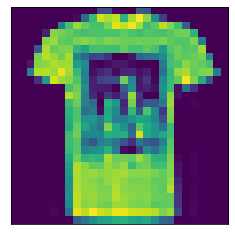

distances:


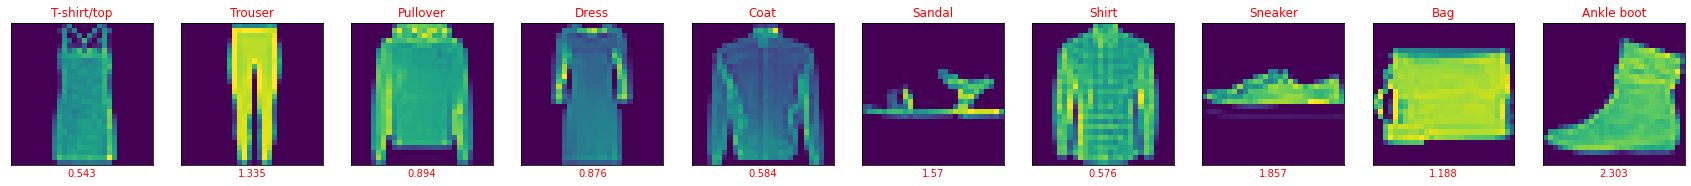

--------------------------------------------------------------------------------
Trouser 1


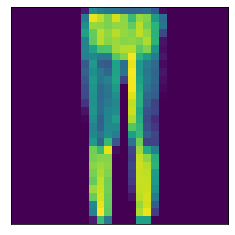

distances:


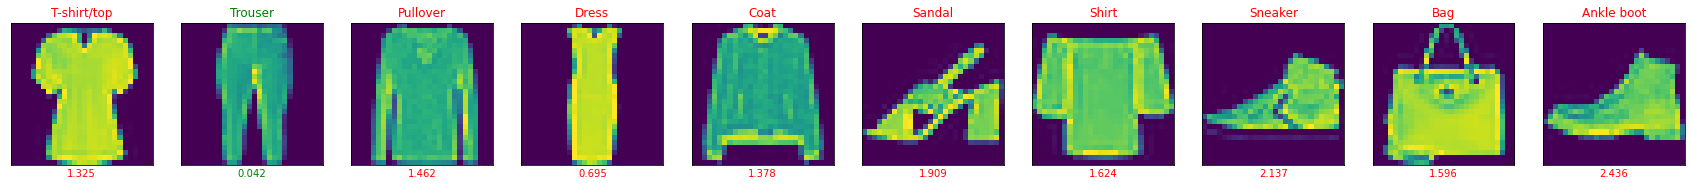

--------------------------------------------------------------------------------
Pullover 2


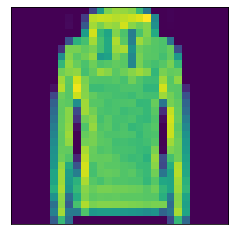

distances:


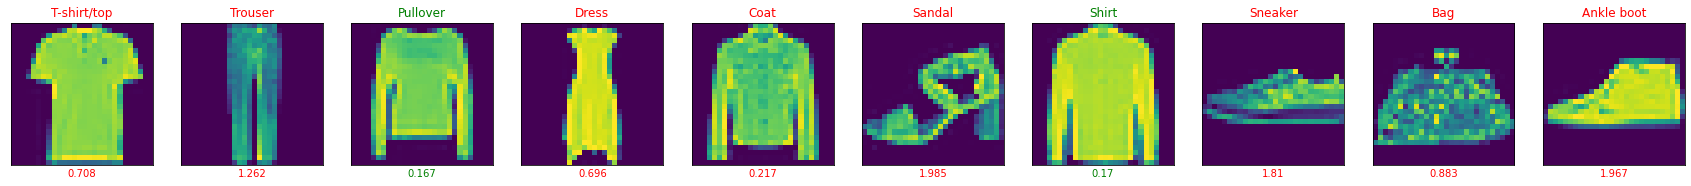

--------------------------------------------------------------------------------
Dress 3


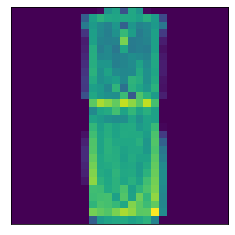

distances:


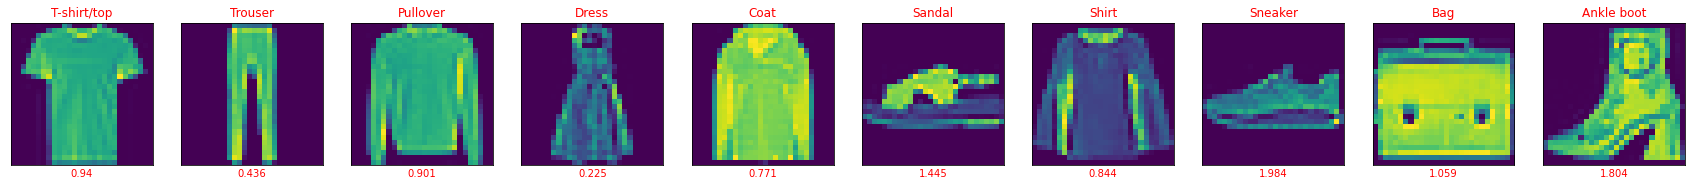

--------------------------------------------------------------------------------
Coat 4


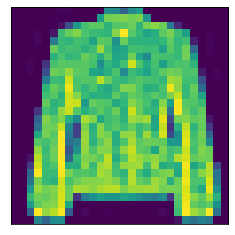

distances:


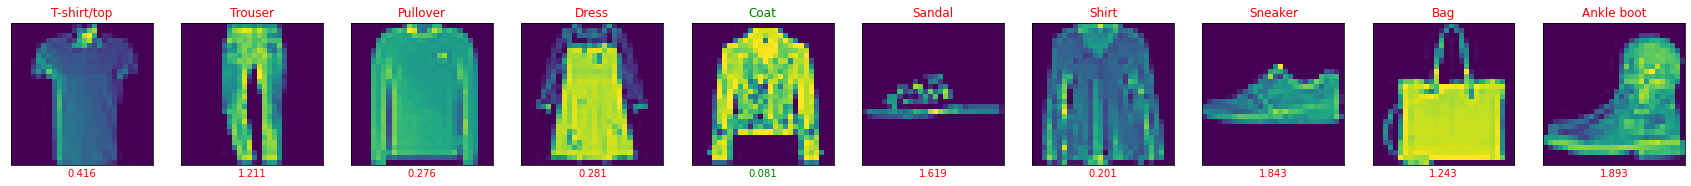

--------------------------------------------------------------------------------
Sandal 5


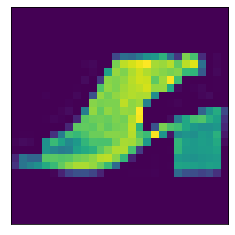

distances:


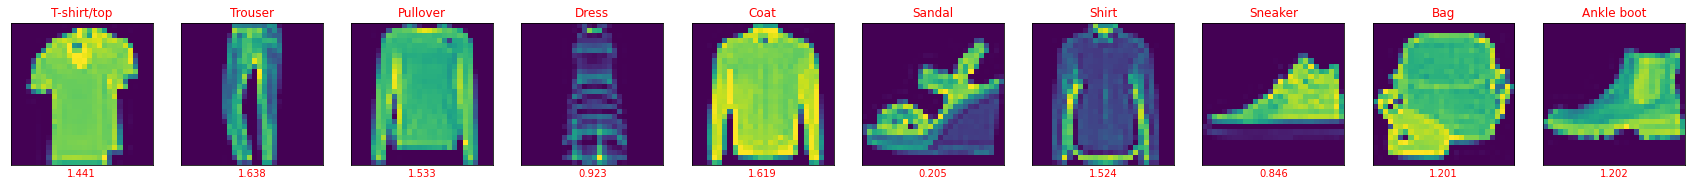

--------------------------------------------------------------------------------
Shirt 6


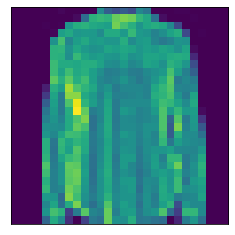

distances:


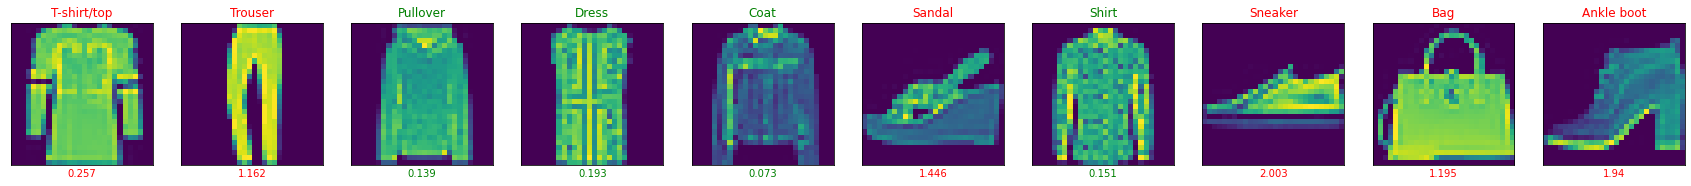

--------------------------------------------------------------------------------
Sneaker 7


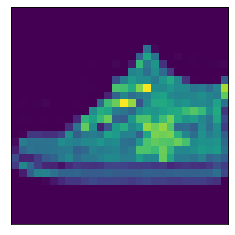

distances:


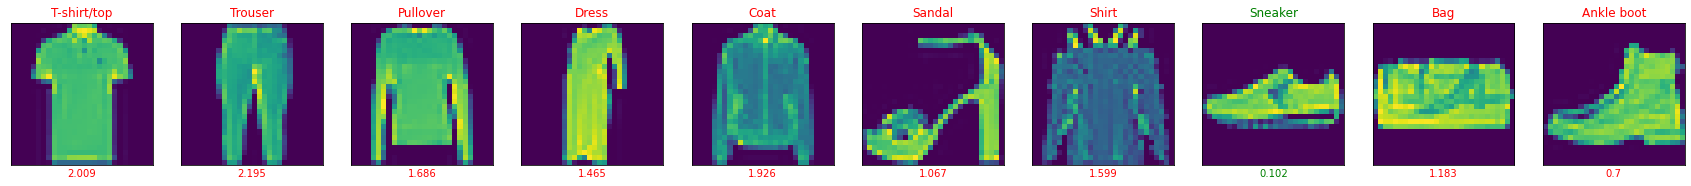

--------------------------------------------------------------------------------
Bag 8


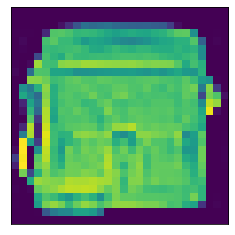

distances:


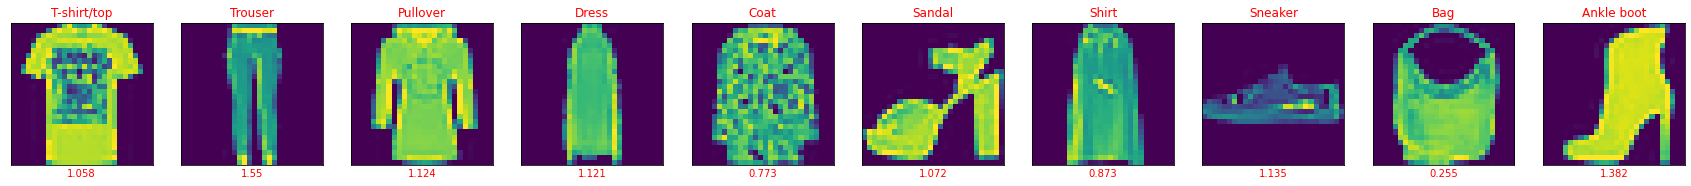

--------------------------------------------------------------------------------
Ankle boot 9


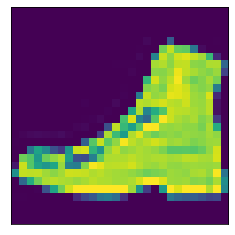

distances:


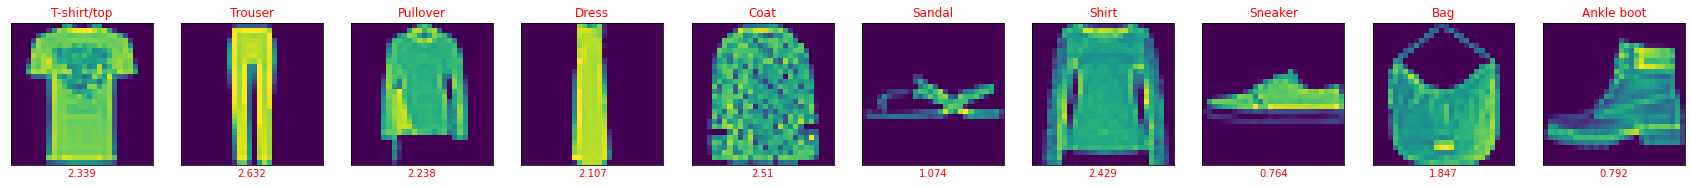

In [ ]:
for class_ind in range(10):
    print('-'*80)
    class_name = class_names[class_ind]
    print(class_name, class_ind)
    class_inds = np.argwhere(test_labels == class_ind).flatten()
    image = np.squeeze(test_images[np.random.choice(class_inds)])
    image_vec = base_model(np.expand_dims(image, 0))

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()
    print('distances:')
    plot_images_dis(base_model, image_vec, test_images, test_labels, class_names)

### Confusion matrix

In [ ]:
test_vecs = base_model(test_images).numpy()
confusion_matrix = calculate_confusion_matrix(test_vecs,
                                              test_labels,
                                              class_names,
                                              samples=99)

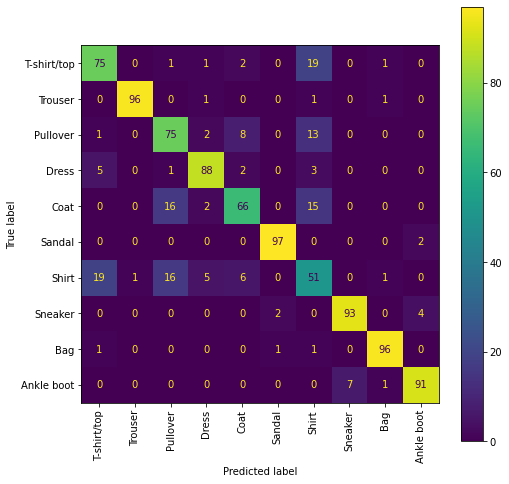

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                             display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8));
cmp.plot(ax=ax, xticks_rotation="vertical", include_values=True)

In [ ]:
import gc
del train_triplets, train_images, test_images
gc.collect()

65772

## Practice

Repeat the process with the flower dataset, a set of **~ 3700 photographs** of flowers from **5 different classes**. Same dataset as [Introduction_to_CNN.ipynb](https://github.com/ezponda/intro_deep_learning_solutions/blob/main/class/CNN/Introduction_to_CNN.ipynb).

Use a pretrained model for the base-model.

In [ ]:
import pathlib
import tensorflow as tf
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
image_size = (96, 96)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 80%  train, 20% validation
    subset=
    'training',  # 'training' o 'validation', only  with 'validation_split'
    seed=1,
    image_size=image_size,# Dimension (img_height, img_width) for rescaling
    batch_size=1
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=1,
    image_size=image_size,
    batch_size=1
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
train_images, train_labels = zip(*[
    (items[0][0], items[1][0]) for items in train_ds.as_numpy_iterator()
])
train_images = np.array(train_images)
train_images = train_images / 255.0
train_labels = np.array(train_labels)
train_images.shape, train_labels.shape

((2936, 96, 96, 3), (2936,))

In [ ]:
test_images, test_labels = zip(*[
    (items[0][0], items[1][0]) for items in val_ds.as_numpy_iterator()
])
test_images = np.array(test_images)
test_images = test_images / 255.0
test_labels = np.array(test_labels)
test_images.shape, test_labels.shape

((734, 96, 96, 3), (734,))

In [ ]:
train_triplets = create_triplets(train_images, train_labels, 5000)
train_triplets.shape

(25000, 3, 96, 96, 3)

### Create the base model
Use a pre-trained model like `MobileNetV2`: [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [ ]:
vec_dim = 128

inputs = tf.keras.Input(shape=image_size+(3,))

## Pre-trained model

pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size+(3,), include_top=False)
pretrained_model.trainable = False
x = pretrained_model(inputs)

## Flatten layer

flat = layers.Flatten()(x)
flat = layers.Dropout(0.3)(flat)

## Output vector
x = layers.Dense(vec_dim, activation='relu')(flat)
x = layers.Dropout(0.3)(x)
x = layers.Dense(vec_dim, activation='linear')(x)
# L2 normalize
x = layers.Lambda(lambda z: tf.math.l2_normalize(z, axis=1))(x)

base_model = tf.keras.Model(inputs=inputs, outputs=x, name='base_model')

base_model.summary()

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 11520)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1474688   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1

In [ ]:
# Input triplets (anchor, positive, negative)
inputs = tf.keras.Input(shape=(3, 96, 96, 3), name='inputs')

## Anchor vector
anchor_input = inputs[:, 0, :, :, : ]
anchor_vec = base_model(anchor_input)

## Positive vector
positive_input = inputs[:, 1, :, :,:]
positive_vec = base_model(positive_input)

## Negative vector
negative_input = inputs[:, 2, :, :,:]
negative_vec = base_model(negative_input)

## stack all the vectors dim: (3, none, vec_dim)
outputs = tf.stack([anchor_vec, positive_vec, negative_vec])
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
y = np.zeros(len(train_triplets))
model.compile(loss=triplet_loss,optimizer='adam')
history = model.fit(train_triplets, y, epochs=1, validation_split=0.15, batch_size=64, shuffle=True)

333/333 [==============================] - 321s 947ms/step - loss: 0.0767 - val_loss: 0.0640


### EXTRA (Optional)

Every one or two epochs, recreate the training triplets by choosing the negative images closest to the anchor to accelerate convergence.
You can use [KDTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree)

In [ ]:
from sklearn.neighbors import KDTree


train_vecs = base_model(train_images).numpy()
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree
class_ind = 0
pos_class_inds = np.argwhere(train_labels == class_ind).flatten()
neg_class_inds = np.argwhere(train_labels != class_ind).flatten()


In [ ]:
from sklearn.neighbors import KDTree
#
#class_ind = 0
#pos_class_inds = np.argwhere(train_labels == class_ind).flatten()
#neg_class_inds = np.argwhere(train_labels != class_ind).flatten()
from tqdm import tqdm

def create_triplets_ordered(train_vecs, images, labels, n_triplets_per_image=5):
    triplets = [] # (anchor, positive, negative)
    n_labels = len(np.unique(labels))
    for class_ind in range(n_labels):
        # Iterate over the classes
        pos_class_inds = np.argwhere(labels == class_ind).flatten()
        neg_class_inds = np.argwhere(train_labels != class_ind).flatten()
        neg_class_vecs = train_vecs[neg_class_inds]
        tree = KDTree(neg_class_vecs, leaf_size=2)
        for anchor_ind in pos_class_inds:
            anchor_vec = train_vecs[anchor_ind].reshape(1, -1)
            pos_inds = np.random.choice(pos_class_inds, n_triplets_per_image)
            dist, ind = tree.query(anchor_vec, k=n_triplets_per_image)
            neg_inds = ind[0]
            for pos, neg in zip(pos_inds, neg_inds):
                anchor = images[anchor_ind]
                positive = images[anchor_ind]
                negative = images[neg_class_inds[neg]]
                triplets.append((anchor, positive, negative))
    triplets = np.array(triplets)
    return triplets

train_vecs = base_model(train_images).numpy()
new_triplets = create_triplets_ordered(train_vecs, train_images, train_labels, n_triplets_per_image=5)
new_triplets.shape

(14680, 3, 96, 96, 3)

In [ ]:
for _ in range(5):
    train_vecs = base_model(train_images).numpy()
    new_triplets = create_triplets_ordered(train_vecs, train_images, train_labels, n_triplets_per_image=5)
    y = np.zeros(len(new_triplets))
    history = model.fit(new_triplets, y, epochs=1, validation_split=0.15, batch_size=64, shuffle=True)

195/195 [==============================] - 164s 843ms/step - loss: 0.0039 - val_loss: 0.0000e+00


### Visualize the results

--------------------------------------------------------------------------------
daisy 0


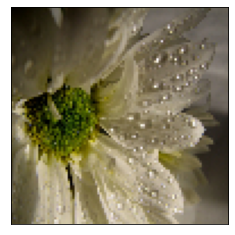

distances:


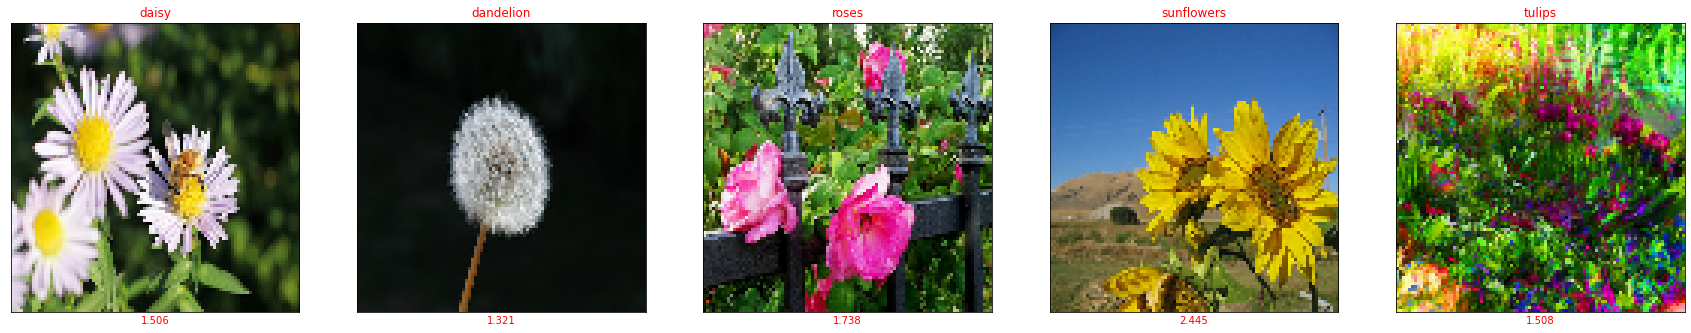

--------------------------------------------------------------------------------
dandelion 1


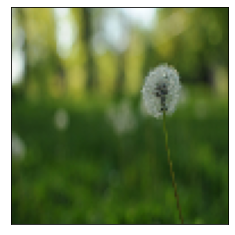

distances:


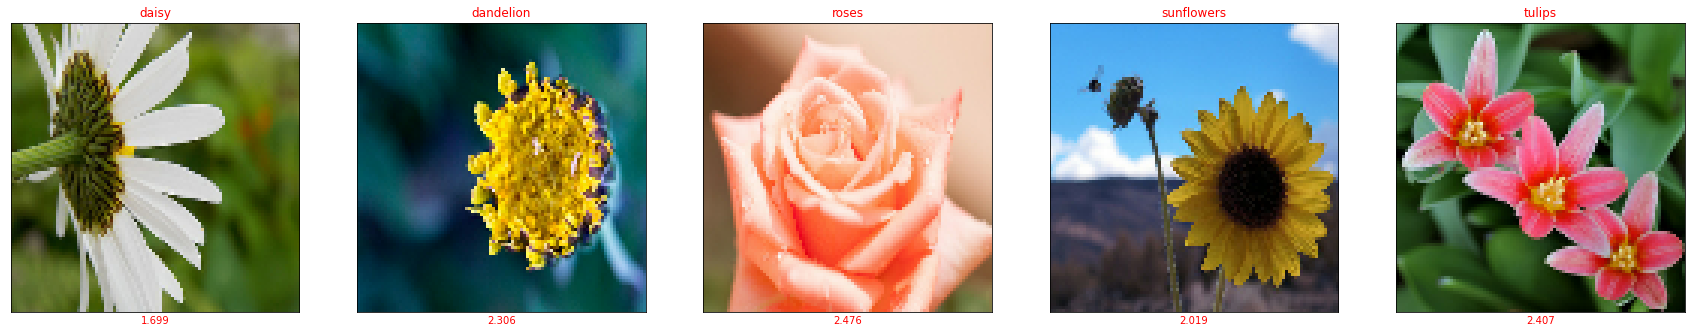

--------------------------------------------------------------------------------
roses 2


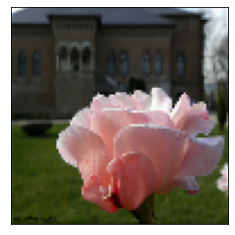

distances:


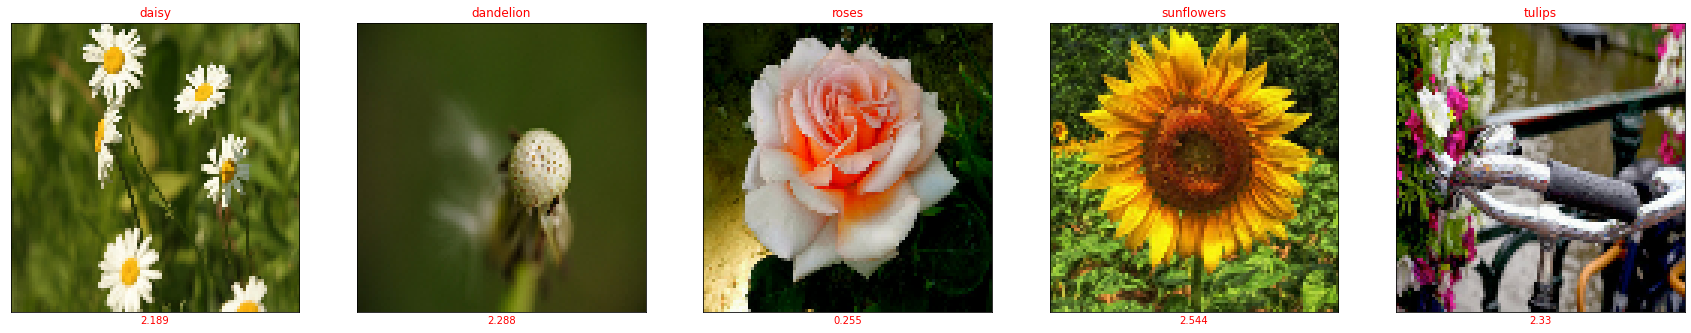

--------------------------------------------------------------------------------
sunflowers 3


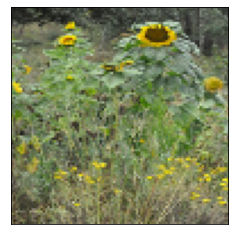

distances:


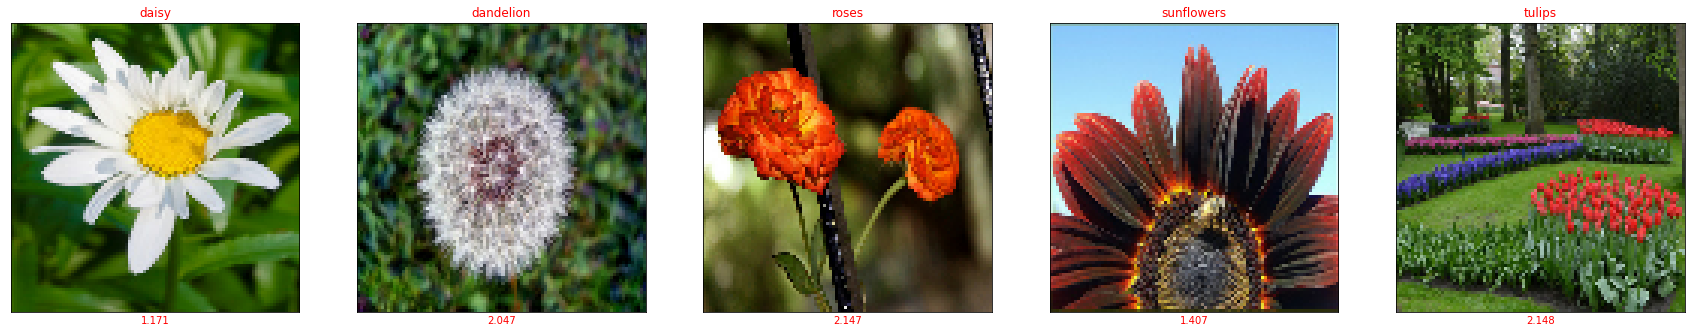

--------------------------------------------------------------------------------
tulips 4


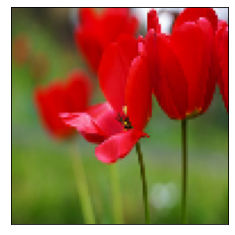

distances:


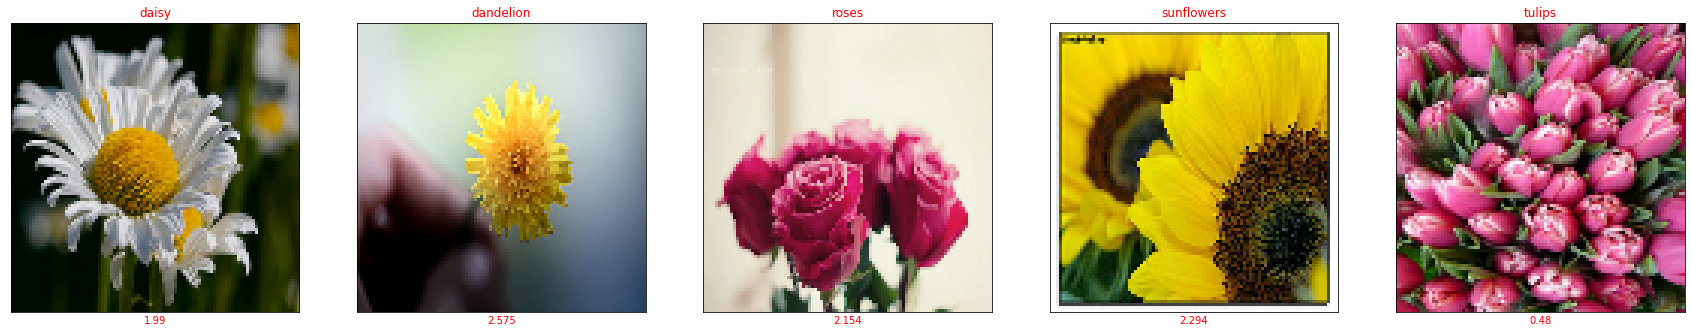

In [ ]:
for class_ind in range(len(class_names)):
    print('-'*80)
    class_name = class_names[class_ind]
    print(class_name, class_ind)
    class_inds = np.argwhere(test_labels == class_ind).flatten()
    image = test_images[np.random.choice(class_inds)]
    image_vec = base_model(np.expand_dims(image, 0))

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()
    print('distances:')
    plot_images_dis(base_model, image_vec, test_images, test_labels, class_names)

In [ ]:
## find nearest image
def find_k_nearest(image_vec, train_vecs, k=1):
    dis_list = []
    for i in range(len(train_vecs)):
        dis = distance(image_vec, train_vecs[i])
        dis_list.append((i, dis))
    dis_list = sorted(dis_list, key=lambda z: z[1])
    return dis_list[:k]

train_vecs = base_model(train_images)

In [ ]:
ind = np.random.randint(len(test_images))
image = np.expand_dims(test_images[ind], 0)
image_vec = base_model(image)
nearest = find_k_nearest(image_vec, train_vecs, k=5)

Random image


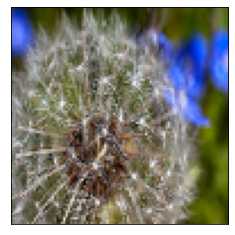


--------------------------------------------------
Nearest


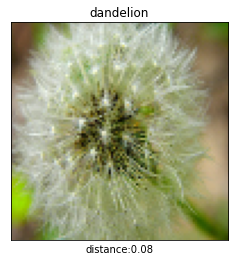

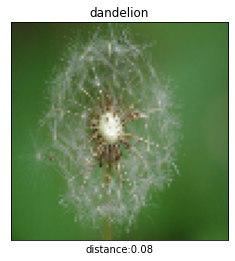

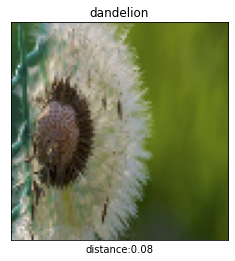

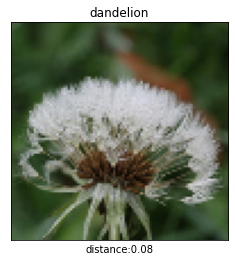

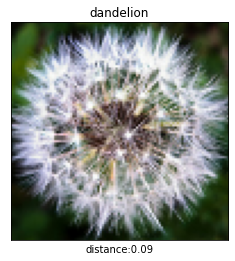

In [ ]:
print('Random image')
plt.imshow(image[0])
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()
print()
print('-' * 50)
print('Nearest')
for ind, dist in nearest:
    img = train_images[ind]
    label = class_names[train_labels[ind]]
    plt.imshow(img)
    plt.xlabel('distance:{0:1.2f}'.format(dist))
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

In [ ]:
## load new image
# clavel
def read_image(image_path, target_size=None, grayscale=False):
    image = tf.keras.preprocessing.image.load_img(image_path,
                                                  target_size=target_size,
                                                  grayscale=grayscale)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.astype(np.uint8)
    return image


url = 'https://hips.hearstapps.com/es.h-cdn.co/mcres/images/mi-casa/terraza-jardines-porche/cuidados-del-clavel/1106673-1-esl-ES/los-cuidados-basicos-del-clavel.jpg?crop=1.00xw:0.889xh;0,0.0886xh&resize=480:*'
image_path = tf.keras.utils.get_file("clavel2.jpg", url)
image = read_image(image_path, target_size=image_size)

image = np.expand_dims(image, 0)
image_vec = base_model(image)
nearest = find_k_nearest(image_vec, train_vecs, k=5)

Image


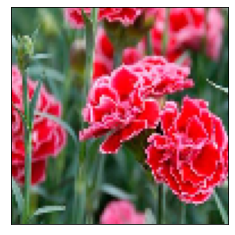


--------------------------------------------------
Nearest


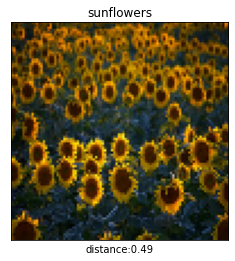

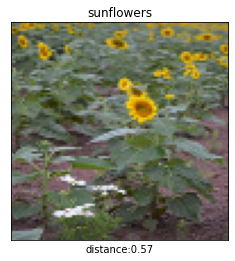

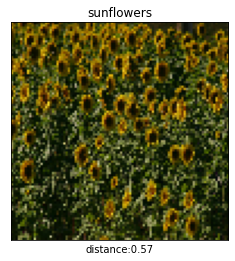

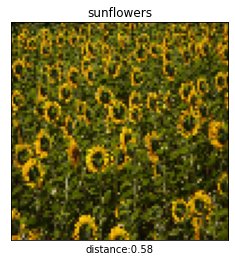

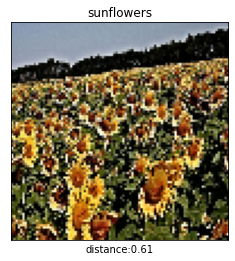

In [ ]:
print('Image')
plt.imshow(image[0])
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()
print()
print('-' * 50)
print('Nearest')
for ind, dist in nearest:
    img = train_images[ind]
    label = class_names[train_labels[ind]]
    plt.imshow(img)
    plt.xlabel('distance:{0:1.2f}'.format(dist))
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

In [ ]:

url = 'https://i.blogs.es/a5bd8a/amapolas-1/450_1000.jpg'
image_path = tf.keras.utils.get_file("amapola.jpg", url)
image = read_image(image_path, target_size=image_size)

image = np.expand_dims(image, 0)
image_vec = base_model(image)
nearest = find_k_nearest(image_vec, train_vecs, k=5)

Image


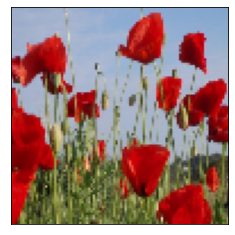


--------------------------------------------------
Nearest


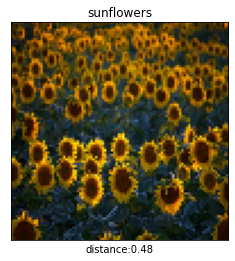

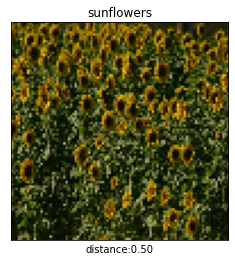

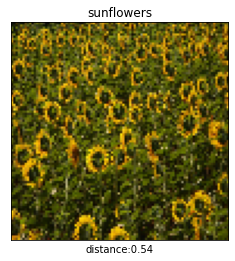

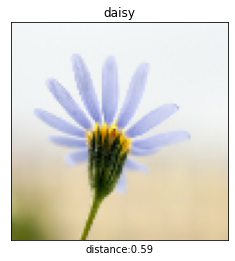

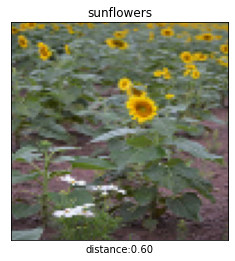

In [ ]:
print('Image')
plt.imshow(image[0])
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()
print()
print('-' * 50)
print('Nearest')
for ind, dist in nearest:
    img = train_images[ind]
    label = class_names[train_labels[ind]]
    plt.imshow(img)
    plt.xlabel('distance:{0:1.2f}'.format(dist))
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()